In [74]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda

np.random.seed(129)

# FashionMNIST

In [76]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor()
)

In [77]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


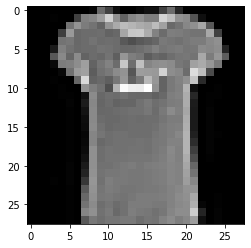

Label: 0


In [78]:
# Display image and label.
batch_x, batch_y = next(iter(train_dataloader))
print(f"Feature batch shape: {batch_x.size()}")
print(f"Labels batch shape: {batch_y.size()}")
img = batch_x[0].squeeze()
label = batch_y[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [81]:
dim_num = training_data[0][0].size()[1] *  training_data[0][0].size()[2]
dim_num

784

# Define Network(s)

In [82]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

class NeuralNetwork(nn.Module):
    def __init__(self, n_hidden=256):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(dim_num, n_hidden),
            nn.ReLU(),
            #nn.Dropout(.1),
            #nn.Linear(n_hidden, n_hidden),
            #nn.ReLU(),
            #nn.Dropout(.1),
            nn.Linear(n_hidden, 10),
            #nn.Softmax(-1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
def getNeuralNet(dim_num=784, n_hidden=256, n_classes=10):
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(dim_num, n_hidden),
        nn.ReLU(),
        #nn.Dropout(.1),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        #nn.Dropout(.1),
        nn.Linear(n_hidden, n_classes)
    )

Using cpu device


In [83]:
net1 = getNeuralNet(dim_num, 32, 10)
net2 = getNeuralNet(dim_num,  8, 10)

In [84]:
#for name, param in model.named_parameters():
#    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

In [85]:
learning_rate = 1e-3
#batch_size = 64
epochs = 4
loss_fn = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(net1.parameters(), lr=learning_rate)
optimizer2 = torch.optim.Adam(net2.parameters(), lr=learning_rate)

# Training

In [89]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    train_losses = []
    for step, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
    return np.mean(train_losses)


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    predictions = []
    
    with torch.no_grad():
        for X,y in dataloader:
            # Compute prediction and loss
            pred = model(X)
            predictions.append(pred)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return predictions

In [90]:
losses1, losses2 = [], []
from rich.progress import track
for t in range(epochs):
    print("Epoch {}/{}".format(t+1,epochs))
    losses1.append(train_loop(train_dataloader, net1, loss_fn, optimizer1))
    losses2.append(train_loop(train_dataloader, net2, loss_fn, optimizer2))
    #test_loop(test, test_labels, model, loss_fn)
print("Done!")

Epoch 1/4
Epoch 2/4
Epoch 3/4
Epoch 4/4
Done!


In [91]:
predictions1 = test_loop(test_dataloader, net1, loss_fn)
predictions2 = test_loop(test_dataloader, net2, loss_fn)

Test Error: 
 Accuracy: 84.5%, Avg loss: 0.006659 

Test Error: 
 Accuracy: 81.5%, Avg loss: 0.008377 



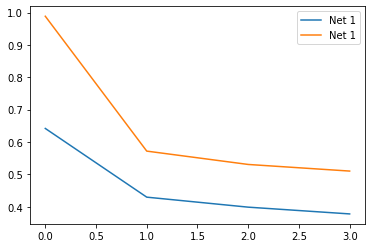

In [92]:
import matplotlib.pyplot as plt
plt.plot(losses1, label='Net 1')
plt.plot(losses2, label='Net 1')
plt.legend()
plt.show()

# Embeddings

In [93]:
# Define function to get subnet from given network at index
def get_subnet(parent_net, break_layer_idx = '1'):
    children_list = []
    for n,c in parent_net.named_children():
        children_list.append(c)
        if n == break_layer_idx:
            break
    sub_net = nn.Sequential(*children_list)
    return sub_net

In [94]:
# Print one of the original networks as reference
net1

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=32, bias=True)
  (4): ReLU()
  (5): Linear(in_features=32, out_features=10, bias=True)
)

In [95]:
# Get the subnetworks
sub_net1 = get_subnet(net1)
sub_net2 = get_subnet(net2)

In [96]:
sub_net1

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
)

In [97]:
# Get DataLoader with larger batch_size
dl = DataLoader(training_data, batch_size=400, shuffle=False)
batch_x, batch_y = next(iter(dl))

In [98]:
# Get embeddings for batch
emb1 = sub_net1(batch_x).detach().numpy()
emb2 = sub_net2(batch_x).detach().numpy()

In [99]:
emb2.shape

(400, 8)

In [103]:
# Get t-SNE embeddings for the outputs
from sklearn.manifold import TSNE
tsne1 = TSNE(n_components=2).fit_transform(emb1)
tsne2 = TSNE(n_components=2).fit_transform(emb2)

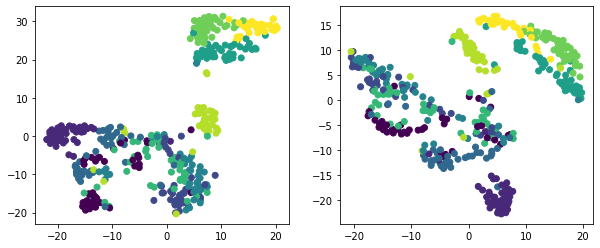

In [104]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(tsne1[:,0], tsne1[:,1], c=batch_y)
plt.subplot(122)
plt.scatter(tsne2[:,0], tsne2[:,1], c=batch_y)
plt.show()

# Embedding Fitness

In [130]:
euclid = lambda x,y: np.linalg.norm(x-y,ord=2)

def p_j_i(embeddings, j, i):
    
    sigmai2 = 1
    
    exp_fn = lambda xj,xi: np.exp(-euclid(xi, xj)**2 / 2*sigmai2)
    
    nominator = exp_fn(embeddings[j], embeddings[i])
    
    denominator = np.sum([
        exp_fn(embeddings[k], embeddings[i])
            for k in range(len(embeddings)) if k != i
    ])
    
    return nominator / denominator

def pij(embeddings, i, j):
    N = len(embeddings)
    return (p_j_i(embeddings, j, i) + p_j_i(embeddings, i, j)) / 2*N

In [138]:
embeddings = np.arange(1,11).reshape((5,2))
embeddings

array([[ 1,  2],
       [ 3,  4],
       [ 5,  6],
       [ 7,  8],
       [ 9, 10]])

In [141]:
p_j_i(embeddings, 1, 1)
#pij(embeddings, j=1, i=1)

[3 4] [3 4]
[3 4] [1 2]
[3 4] [5 6]
[3 4] [7 8]
[3 4] [ 9 10]


27.29899115117264